In [6]:
import pandas as pd
from pprint import pprint
import glob
import pandas as pd
pd.set_option('display.max_rows', None)
# jupyter nbconvert --to script 04b_combine_results_find_disagreement.ipynb

for model_type in ["dictionary", "biolord"]:
    output_folder = f"../exports/selected_reports_with_event_log_only_{model_type}"
    output_file = f"{output_folder}/combined.pkl"
    batch_files = sorted(glob.glob(f"{output_folder}/batch_*.pkl"))
    combined_df = pd.concat([pd.read_pickle(f) for f in batch_files], ignore_index=True)
    combined_df.to_pickle(output_file)
   

def prepare_df(df, type="biolord"):
    df = df.copy()
    df['Sent_ID'] = df['Events'].apply(lambda x: [i for i in range(len(x))])
    df['UID'] = df['ROW_ID'].astype(str) + "_" + df['Sent_ID'].astype(str)
    df = df.explode(["Sent_ID","Events"])
    df = df.dropna(subset="Events")
    df['Event_Name'] = df['Events'].apply(lambda x: x['event'])
    df['Sentence'] = df['Events'].apply(lambda x: x['sentence'])
    df['Time'] = df['Events'].apply(lambda x: x['event_detection_time'])
    
    if type == "dictionary":
        df['Keyword'] = df['Events'].apply(lambda x: x['keyword'])
    if type == "biolord":
        df['Similarity'] = df['Events'].apply(lambda x: x['similarity'])
        df['Similarity'] = df['Similarity'].apply(lambda x: {k:v for (k,v) in x.items() if k!="Alert And Oriented"})
        df["Sleep_similarity"] = df['Similarity'].apply(lambda x:x["Sleep"])
        df["Pain_similarity"] = df['Similarity'].apply(lambda x:x["Pain"])
        df["Excretion_similarity"] = df['Similarity'].apply(lambda x:x["Excretion"])
        df["Eating_similarity"] = df['Similarity'].apply(lambda x:x["Eating"])
        df["Family_similarity"] = df['Similarity'].apply(lambda x:x["Family"])
        # df["Alert And Oriented_similarity"] = df['Similarity'].apply(lambda x:x["Alert And Oriented"])
    return df
df_dictionary = prepare_df(pd.read_pickle("../exports/selected_reports_with_event_log_only_dictionary/combined.pkl"),type="dictionary")
df_biolord = prepare_df(pd.read_pickle("../exports/selected_reports_with_event_log_only_biolord/combined.pkl"), type = "biolord")






In [7]:
pdf = pd.read_pickle("../exports/selected_reports_with_event_log_only_dictionary/combined.pkl")
len(pdf), len(prepare_df(pdf,"dictionary"))

(15223, 338395)

In [8]:
# df_biolord.Similarity = df_biolord.Similarity.astype(str)
df_both = pd.merge(df_dictionary[['ROW_ID','Sent_ID','HADM_ID','CHARTTIME','STORETIME','Sentence','Event_Name','Keyword','CGID','Time']], 
         df_biolord[['ROW_ID','Sent_ID','HADM_ID','CHARTTIME','STORETIME','Sentence','Event_Name','CGID','Similarity','Eating_similarity', 'Excretion_similarity', 'Family_similarity', 'Pain_similarity', 'Sleep_similarity','Time']], 
         on=['HADM_ID','ROW_ID','Sent_ID'], how='outer',suffixes=("_dictionary","_biolord")).sort_values(by=['HADM_ID','ROW_ID','Sent_ID'])
event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
df_both["Event_Name_dictionary_multi"] = df_both["Event_Name_dictionary"].apply(lambda x: {i: x.count(i) if isinstance(x, list) else 0 for i in event_types})


In [9]:
len(df_dictionary), len(df_biolord), len(df_both)

(338395, 338395, 338395)

ValueError: Invalid format specifier '0.2f%' for object of type 'float'

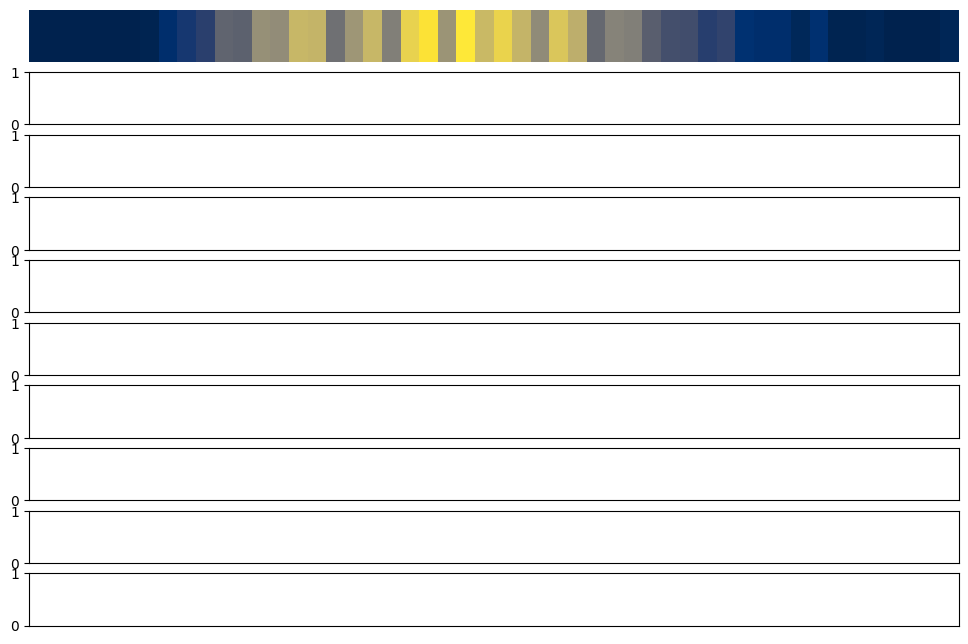

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def plot_axis(counts, i, ax, column, num_bins, bin_edges):
    # Plot 1D heatmap
    # sns.heatmap(
    #     [counts],
    #     ax=ax,
    #     cmap="viridis",
    #     cbar=False,
    #     xticklabels=False if i < len(similarity_columns) - 1 else True,
    #     yticklabels=False
    # )
    norm_counts = counts / counts.sum() * 100

    sns.heatmap(
    [norm_counts],
    ax=ax,
    cmap="cividis",
    cbar=False,
    xticklabels=False if i < len(similarity_columns) - 1 else True,
    yticklabels=False,
    annot=[norm_counts],                 # Annotations need to match the shape of data (1 row)
    fmt='0.2f',                        # Integer format
    annot_kws={"size": 6, "color": "black", "rotation": 90, "va": "center", "ha": "center"}  # Styling
)
    if i%2==0:
        pref = "W"
    else:
        pref = "W/o"
    # Label each heatmap
    ax.set_ylabel(f"{pref} {column} KW \n Total:{counts.sum()}", rotation=0, labelpad=50, va='center')
    ax.set_yticks([])

    # Only format x-ticks for the bottom axis
    if i == 9:
        # Compute bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Choose a few bin positions to label
        tick_indices = np.linspace(0, num_bins - 1, 25).astype(int)
        tick_labels = [f"{bin_centers[j]:.2f}" for j in tick_indices]

        # Now set ticks and labels
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels, rotation=90, ha="right")


# Similarity columns to plot
similarity_columns = [
    "Eating",
    "Excretion",
    "Family",
    "Pain",
    "Sleep"
]

# Compute global min and max for consistent binning
all_values = np.concatenate([df_both[f"{col}_similarity"].dropna().values for col in similarity_columns])
global_min, global_max = all_values.min(), all_values.max()

# Define consistent bins
num_bins = 50
bin_edges = np.linspace(global_min, global_max, num_bins + 1)

# Create subplots
fig, axes = plt.subplots(
    nrows=len(similarity_columns)*2,
    figsize=(12, 8),
    sharex=True
)

for i, ax in enumerate(axes):
    column = similarity_columns[i//2]
    event_type = column
    if i%2 == 0:
        df_sel = df_both[df_both["Event_Name_dictionary"].apply(lambda x: "_".join(set(x)) == event_type )]
    else:
        df_sel = df_both[df_both["Event_Name_dictionary"].apply(lambda x: event_type not in x and "_".join(set(x))!='Unknown' )]
    counts, _ = np.histogram(df_sel[f"{event_type}_similarity"].dropna(), bins=bin_edges)

    plot_axis(counts, i, ax, column, num_bins, bin_edges)

# Add title and x label
axes[0].set_title("1D Heatmap Histograms of Similarities")
axes[-1].set_xlabel("Similarities with Corresponding Event Types")

plt.tight_layout()
plt.show()


In [39]:
df_both.columns, df_both.Event_Name_dictionary.value_counts()

(Index(['ROW_ID', 'Sent_ID', 'HADM_ID', 'CHARTTIME_dictionary',
        'STORETIME_dictionary', 'Sentence_dictionary', 'Event_Name_dictionary',
        'Keyword', 'CGID_dictionary', 'Time_dictionary', 'CHARTTIME_biolord',
        'STORETIME_biolord', 'Sentence_biolord', 'Event_Name_biolord',
        'CGID_biolord', 'Similarity', 'Eating_similarity',
        'Excretion_similarity', 'Family_similarity', 'Pain_similarity',
        'Sleep_similarity', 'Time_biolord', 'Event_Name_dictionary_multi'],
       dtype='object'),
 Event_Name_dictionary
 [Unknown]                                                   309970
 [Pain]                                                        9100
 [Family]                                                      7036
 [Excretion]                                                   5776
 [Sleep]                                                       2118
 [Eating]                                                      1647
 [Family, Family]                            

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ecdf(sample, label=None):
    if len(sample) > 0:
        sns.ecdfplot(sample, label=label)
        if label:
            plt.legend()
        
        
event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
df_both["Event_Name_dictionary_multi"] = df_both["Event_Name_dictionary"].apply(lambda x: {i: x.count(i) if isinstance(x, list) else 0 for i in event_types})


disagreement_1_list = []
disagreement_2_list = []
agreement_1_list = []
agreement_2_list = []
for selected_event_type in event_types:
    print(selected_event_type)
    df_both[f'contains_{selected_event_type}'] = df_both["Event_Name_dictionary_multi"].apply(lambda x: True if (selected_event_type in set(x) and len(set(x)) == 1) else False)
    for threshold in ["0_2"]:
        th = float(threshold.replace("_","."))
        # df_both[f'only_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type in set(x) and len(set(x)) == 1) else False)
        # df_both[f'contains_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type in set(x) and len(set(x)) > 1) else False)
        # df_both[f'contains_1ormore_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type in set(x)) else False)
        # df_both[f'no_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type not in set(x) and (len(set(x)) == 1) and  set(x).pop() in event_types) else False)
        df_both[f"disagreement_only_{selected_event_type}_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'only_{selected_event_type}'] and x[f'{selected_event_type}_similarity']<th) else False, axis=1)
        df_both[f"disagreement_no_{selected_event_type}_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'no_{selected_event_type}'] and x[f'{selected_event_type}_similarity']>=th) else False, axis=1)
        
        disagreement1 = df_both[df_both[f"disagreement_only_{selected_event_type}_th_0_2"]]
        disagreement2 = df_both[df_both[f"disagreement_no_{selected_event_type}_th_0_2"]]
        common_to_both_disagreement = df_both[df_both[f"disagreement_only_{selected_event_type}_th_0_2"] & df_both[f"disagreement_no_{selected_event_type}_th_0_2"]]
        print(selected_event_type, len(disagreement1), len(disagreement2), len(common_to_both_disagreement),len(df_both[df_both[f'contains_1ormore_{selected_event_type}']]))
        plot_ecdf(df_both[df_both[f"only_{selected_event_type}"]][f"{selected_event_type}_similarity"], label=f"only_{selected_event_type}")
        plot_ecdf(df_both[df_both[f"contains_{selected_event_type}"]][f"{selected_event_type}_similarity"], label=f"contains_{selected_event_type}")
        plot_ecdf(df_both[df_both[f"no_{selected_event_type}"]][f"{selected_event_type}_similarity"], label=f"no_{selected_event_type}")
        plt.show()
        disagreement_1_list.append(disagreement1)
        disagreement_2_list.append(disagreement2)
        
    df_both[f"disagreement_unknown_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'Event_Name_dictionary']=="Unknown" and any([x[f'{selected_event_type}_similarity']>=th for selected_event_type in event_types])) else False, axis=1)
    df_both[f"disagreement_multi_th_{threshold}"] = df_both.apply(lambda x: True if (len(x[f'Event_Name_dictionary'])>1 and all([x[f'{selected_event_type}_similarity']<=th for selected_event_type in event_types])) else False, axis=1)
    disagreement1_df = pd.concat(disagreement_1_list)    
    disagreement2_df = pd.concat(disagreement_2_list) 
    disagreement3_df = df_both[df_both[f"disagreement_unknown_th_{threshold}"]]
    disagreement4_df = df_both[df_both[f"disagreement_multi_th_{threshold}"]]

In [ ]:
df_both[df_both[f'contains_1ormore_Eating']]['Keyword'].value_counts()

df_both[df_both.Keyword.apply(lambda x: True if 'biting' in x else False)].to_excel('../exports/temp_view_biting.xlsx')

In [ ]:
df_both

In [ ]:
disagreement2_df.Event_Name_dictionary.value_counts()

In [ ]:
print(len(disagreement2_df))
disagreement2_df['Event_Name_dictionary_set'] = disagreement2_df['Event_Name_dictionary'].apply(lambda x: "_".join(sorted(list(set(x)))))
def stratified_sample_df(df, col):
    # Get the size of the smallest group
    min_count = df[col].value_counts().min()

    # Sample min_count rows from each group
    samples = (
        df.groupby(col)
        .apply(lambda x: x.sample(n=min_count, random_state=1))
        .reset_index(drop=True)
    )

    return samples

disagreement2_df_startified = stratified_sample_df(disagreement2_df,"Event_Name_dictionary_set")

In [ ]:
disagreement2_df.Event_Name_dictionary_set.value_counts(), disagreement2_df_startified.Event_Name_dictionary_set.value_counts()

In [ ]:
len(disagreement1_df)

In [ ]:
import pandas as pd
import os, sys
from datetime import datetime

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from utils.event_extractor import EventExtractor

def extract_events(sentences, extractor, evidence={'keywords':[],'event_names':[],'similarities':[]}):
    event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
    events = extractor.extract_events(sentences=sentences, event_names=event_types, threshold=0.2, prompt_evidence=evidence)
    return events




In [ ]:
os.makedirs("../exports/disagreements", exist_ok=True)
for file_name,disagreement_df_temp in {"only_event_mention":disagreement1_df.copy(), 
                                  "no_particular_event_mention":disagreement2_df.copy(),
                                  "unknown_event":disagreement3_df.copy(),
                                  "multi_event":disagreement4_df.copy()}.items():
    print(file_name, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    disagreement_df_temp['Keyword_set'] = disagreement_df_temp['Keyword'].apply(lambda x: list(set(x)))
    disagreement_df_temp['Event_set'] = disagreement_df_temp['Event_Name_dictionary'].apply(lambda x: list(set(x))[0])
    disagreement_df_temp["LLM_Events_no_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"))
    disagreement_df_temp["LLM_Events_dict_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':disagreement_df_temp.Keyword_set.tolist(), 
                                                                        'event_names':disagreement_df_temp.Event_set.tolist(), 
                                                                        'similarities':[]})
    disagreement_df_temp["LLM_Events_embedder_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':[], 
                                                                        'event_names':[], 
                                                                        'similarities':disagreement_df_temp.Similarity.tolist()})
    disagreement_df_temp["LLM_Events_all_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':disagreement_df_temp.Keyword_set.tolist(), 
                                                                        'event_names':disagreement_df_temp.Event_set.tolist(), 
                                                                        'similarities':disagreement_df_temp.Similarity.tolist()})
    disagreement_df_temp['Event_Name_LLM_Events_no_evidence'] = disagreement_df_temp['LLM_Events_no_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_dict_evidence'] = disagreement_df_temp['LLM_Events_dict_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_embedder_evidence'] = disagreement_df_temp['LLM_Events_embedder_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_all_evidence'] = disagreement_df_temp['LLM_Events_all_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp.to_pickle(f"../exports/disagreements/{file_name}.pkl")
    

In [ ]:
disagreement_df_temp[['Event_Name_dictionary','Event_Name_biolord','Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']]

In [ ]:
disagreement_df_temp["LLM_Events_all_evidence"].iloc[0]